In [50]:
import os
from glob import glob
from tqdm import tqdm
import json
from collections import defaultdict
import random
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn

from opensrc.SemanticGuidedHumanMatting.model.model import HumanSegment, HumanMatting
from opensrc.SemanticGuidedHumanMatting import utils
from opensrc.SemanticGuidedHumanMatting import inference
import config

## aihub 데이터셋 가공후 로컬 디스크에 저장

In [20]:
aihub_dir = config.AIHUB_DATA_DIR
train_dir = '/media/shin/T7/dataset/data/training'
val_dir = '/media/shin/T7/dataset/data/validation'

In [59]:
def userid_label(csv_path):
    ord_df = pd.read_csv(csv_path)
    df = pd.DataFrame(ord_df.values[1:, 2:])
    df.columns = ['user_id'] + list(ord_df.values[0, 3:])
    
    label = df[['키', '젖가슴둘레', '허리둘레', '엉덩이둘레', '넙다리둘레', '팔길이', '엉덩이높이', '어깨사이너비']].values[0].astype(np.float)
    user_id = df['user_id'].values[0]
    weight = df['몸무게'].values[0]
    sex = float(df['성별'].values[0] == 'M')
    return user_id, label, float(weight), sex

In [60]:
def user_images(user_id):
    image_dir_dict = {cloth_cat: {'front_dirs': [], 'side_dirs': []} for cloth_cat in config.CLOTH_CATEGORY}

    for json_path in glob(os.path.join(train_dir, f'jsons/TL_{user_id}/json/*')):
        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        
            image_name = json_data['images']['identifier']
            image_dir = os.path.join(train_dir, f'image_csv/{user_id}/Image/{image_name}')
            if json_data['camera_number'] in (3, 4) and json_data['position'] == 'A자':
                image_dir_dict[json_data['cloth']]['front_dirs'] += [image_dir]
            elif json_data['camera_number'] in (11, 12) and json_data['position'] == '차렷':
                image_dir_dict[json_data['cloth']]['side_dirs'] += [image_dir]
        except Exception as e:
            print(e, json_path)
            continue

    return image_dir_dict

### main

In [61]:
json_id = 0
if not os.path.exists(config.AIHUB_DATA_DIR):
    os.mkdir(config.AIHUB_DATA_DIR)

aihub_train_dir = os.path.join(config.AIHUB_DATA_DIR, 'train')
if not os.path.exists(aihub_train_dir):
    os.mkdir(aihub_train_dir)

for csv_path in tqdm(glob(os.path.join(train_dir, 'image_csv/*/csv/*.csv'))):
    try:
        user_id, label, weight, sex = userid_label(csv_path)
    except Exception as e:
        print(e, csv_path)
        continue
    image_dir_dict = user_images(user_id)

    for cloth_cat in image_dir_dict:
        for front_dir in image_dir_dict[cloth_cat]['front_dirs']:
            for side_dir in image_dir_dict[cloth_cat]['side_dirs']:
                user_dict = {
                    "input": {
                        "front": front_dir, 
                        "side": side_dir,
                        "height": label[0], 
                        "weight": weight,
                        "sex": sex
                    }, 
                    "output": {
                        meas: label[i] for i, meas in enumerate(config.MEASUREMENTS_ORDER)
                    }
                }
                with open(os.path.join(aihub_train_dir, f'{json_id}.json'), 'w') as f:
                    json.dump(user_dict, f)
                json_id += 1

  0%|          | 0/492 [00:00<?, ?it/s]

 10%|▉         | 49/492 [00:20<03:09,  2.34it/s]

Expecting value: line 1 column 1 (char 0) /media/shin/T7/dataset/data/training/jsons/TL_F057/json/02_03_F057_20.json


100%|██████████| 492/492 [01:38<00:00,  4.99it/s]


### segmentation model load

In [48]:
model = HumanMatting(backbone='resnet50')
model = nn.DataParallel(model).eval()
model.load_state_dict(torch.load(config.SEGMODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

## segmentation을 통해 masked된 이미지를 저장

In [65]:
def preprocessing(arr):
    arr = np.fliplr(arr)
    arr = np.rot90(arr)
    return arr

In [66]:
pathes = glob(os.path.join('/home/shin/VScodeProjects/fittering-ML/data/source/aihub/train', '*.json'))

for json_path in tqdm(pathes, desc="generate masked data"):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    front_dir = json_data['input']['front']
    side_arr = json_data['input']['side']
    front_arr = plt.imread(front_dir)
    front_arr = preprocessing(front_arr)
    side_arr = plt.imread(side_dir)
    side_arr = preprocessing(side_arr)

    front_masked, _ = inference.single_inference(model, Image.fromarray(front_arr))
    side_masked, _ = inference.single_inference(model, Image.fromarray(side_arr))
    
    plt.imsave(front_dir[:-4] + "_mask" + front_dir[-4:], front_masked)
    plt.imsave(side_dir[:-4] + "_mask" + side_dir[-4:], side_masked)

(2940, 1960)


## segmentation 결과 확인

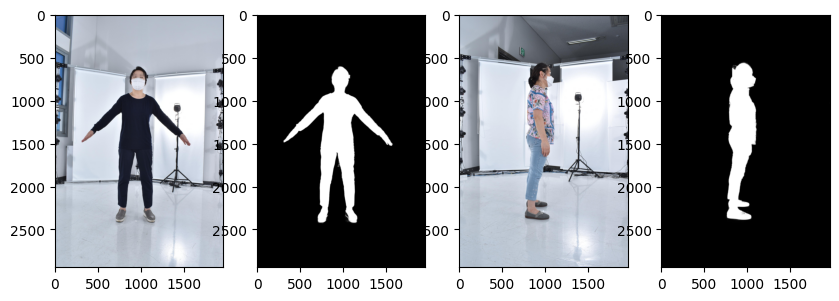

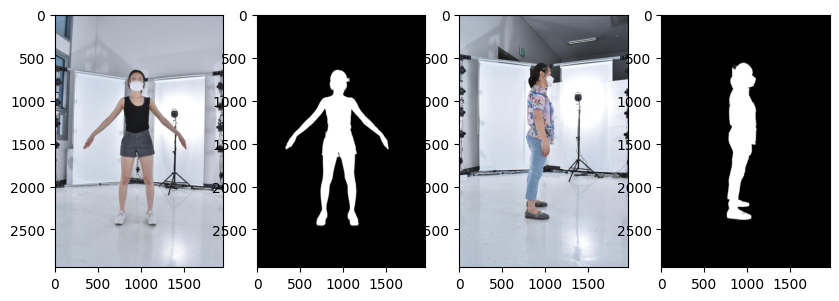

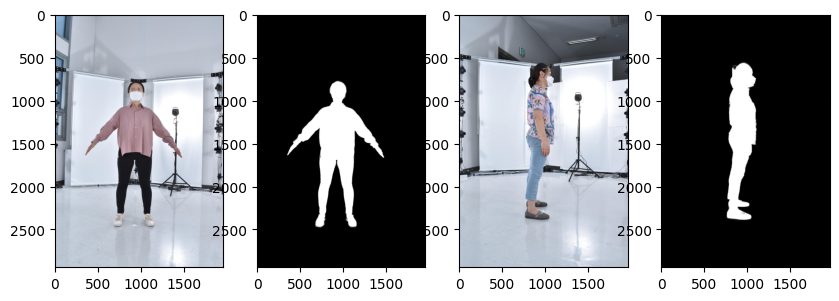

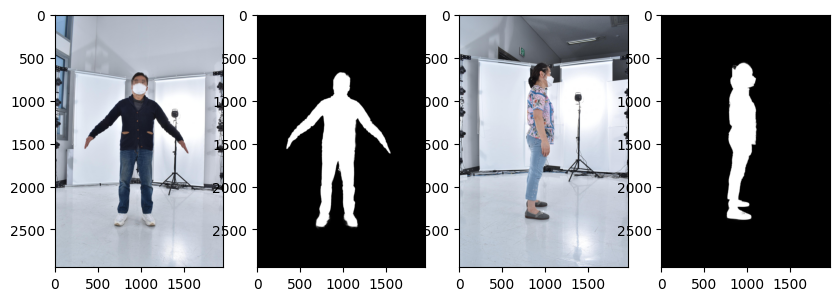

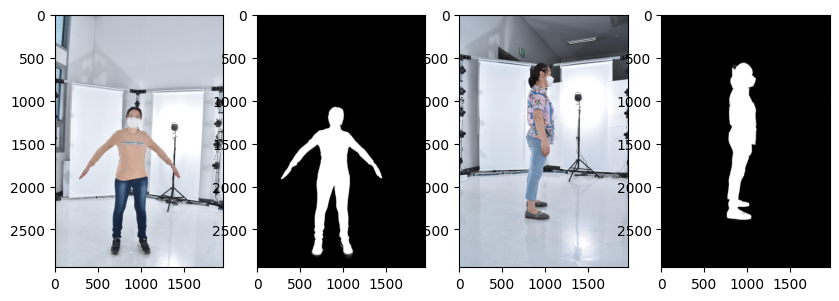

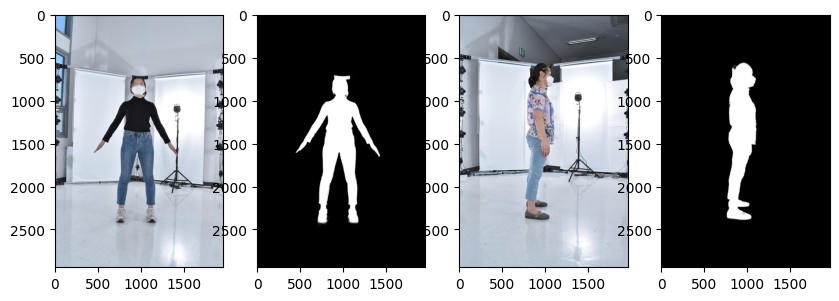

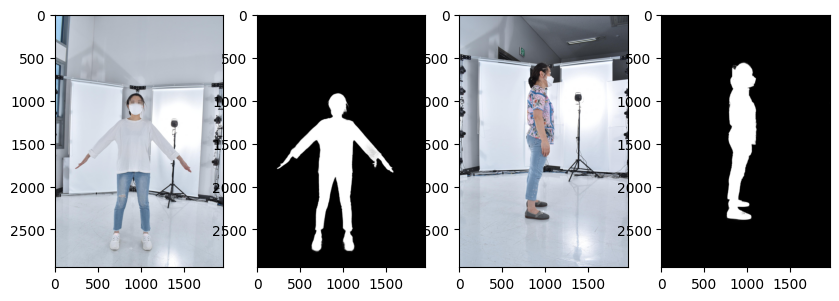

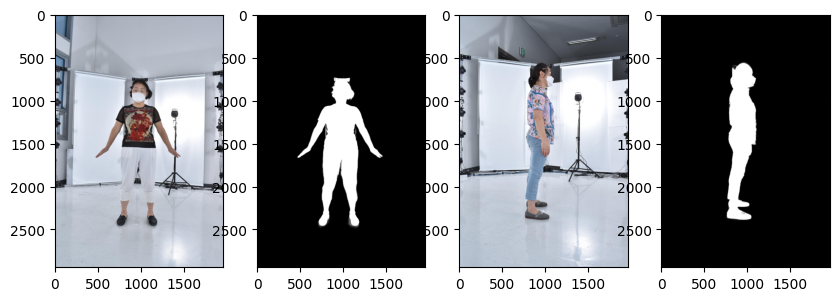

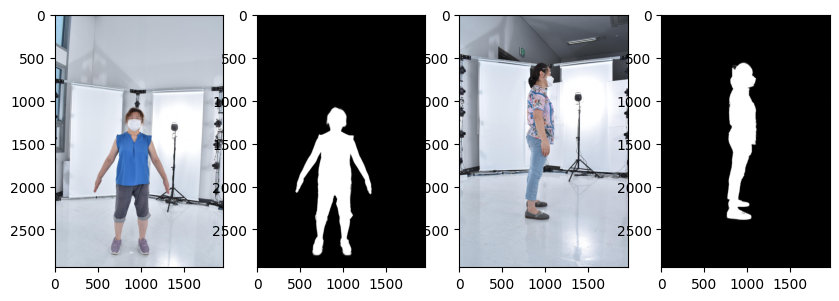

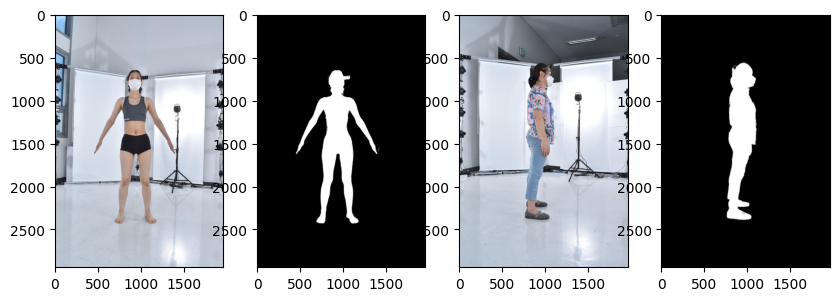

In [67]:
pathes = glob(os.path.join('/home/shin/VScodeProjects/fittering-ML/data/source/aihub/train', '*.json'))
pathes = np.random.choice(pathes, 10)

for json_path in pathes:
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    front_dir = json_data['input']['front']
    side_arr = json_data['input']['side']
    
    front_arr = plt.imread(front_dir)
    front_arr = preprocessing(front_arr)
    side_arr = plt.imread(side_dir)
    side_arr = preprocessing(side_arr)

    front_masked, _ = inference.single_inference(model, Image.fromarray(front_arr))
    side_masked, _ = inference.single_inference(model, Image.fromarray(side_arr))
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))
    axes[0].imshow(front_arr)
    axes[1].imshow(front_masked, cmap='gray')
    axes[2].imshow(side_arr)
    axes[3].imshow(side_masked, cmap='gray')
    plt.show()